In [1]:
# Install necessary libraries
!pip install pubnub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from google.colab import drive
from pubnub.pubnub import PubNub
from pubnub.pnconfiguration import PNConfiguration
from pubnub.callbacks import SubscribeCallback
import time
import itertools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from google.colab import drive
from pubnub.pubnub import PubNub
from pubnub.pnconfiguration import PNConfiguration
from pubnub.callbacks import SubscribeCallback
import time

In [4]:
# Configuration for PubNub
pnconfig = PNConfiguration()
pnconfig.subscribe_key = 'sub-c-99084bc5-1844-4e1c-82ca-a01b18166ca8'
pnconfig.uuid = 'MyIdentifier'

pubnub = PubNub(pnconfig)

In [5]:
# Initialize a DataFrame to store the data
df = pd.DataFrame(columns=['symbol', 'order_quantity', 'bid_price', 'trade_type', 'timestamp'])

In [6]:
# Callback to handle incoming messages
class MySubscribeCallback(SubscribeCallback):
    def __init__(self, max_messages=1000):
        super().__init__()
        self.max_messages = max_messages
        self.messages_received = 0

    def message(self, pubnub, message):
        global df
        # Extract data from the message
        msg = message.message
        print(msg)  # Print the message for verification
        # Append the message to the DataFrame
        df = df._append(msg, ignore_index=True)
        self.messages_received += 1
        # Check if reached max messages
        if self.messages_received >= self.max_messages:
            pubnub.unsubscribe_all()
            print("Reached max messages. Stopping further subscriptions.")

# Subscribe to PubNub channel
max_messages = 1000  # Adjust as needed
pubnub.add_listener(MySubscribeCallback(max_messages=max_messages))
pubnub.subscribe().channels(['pubnub-market-orders']).execute()

# Wait for data collection (adjust time as needed)
time.sleep(100)

# Optional: Data Storage to Google Drive
drive.mount('/content/drive')
df.to_csv('/content/drive/My Drive/market_orders.csv', index=False)

{'symbol': 'Bespin Gas', 'order_quantity': 472, 'bid_price': 229.17, 'trade_type': 'fill or kill', 'timestamp': 1719558304828}
{'symbol': 'Linen Cloth', 'order_quantity': 581, 'bid_price': 227.2, 'trade_type': 'market', 'timestamp': 1719558305079}
{'symbol': 'Bespin Gas', 'order_quantity': 948, 'bid_price': 183.17, 'trade_type': 'limit', 'timestamp': 1719558305329}
{'symbol': 'Apple', 'order_quantity': 919, 'bid_price': 190.51, 'trade_type': 'day', 'timestamp': 1719558305579}
{'symbol': 'Apple', 'order_quantity': 184, 'bid_price': 183.72, 'trade_type': 'day', 'timestamp': 1719558305829}
{'symbol': 'Bespin Gas', 'order_quantity': 822, 'bid_price': 373.4, 'trade_type': 'stop', 'timestamp': 1719558306080}
{'symbol': 'Google', 'order_quantity': 856, 'bid_price': 119.41, 'trade_type': 'market', 'timestamp': 1719558306330}
{'symbol': 'Apple', 'order_quantity': 498, 'bid_price': 186.98, 'trade_type': 'day', 'timestamp': 1719558306580}
{'symbol': 'Linen Cloth', 'order_quantity': 514, 'bid_pric

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'symbol': 'Linen Cloth', 'order_quantity': 320, 'bid_price': 244.05, 'trade_type': 'fill or kill', 'timestamp': 1719558487794}
{'symbol': 'Elerium', 'order_quantity': 396, 'bid_price': 35.59, 'trade_type': 'fill or kill', 'timestamp': 1719558488044}
{'symbol': 'Bespin Gas', 'order_quantity': 463, 'bid_price': 343.94, 'trade_type': 'market', 'timestamp': 1719558488293}
{'symbol': 'Elerium', 'order_quantity': 71, 'bid_price': 208.49, 'trade_type': 'day', 'timestamp': 1719558488544}
{'symbol': 'Google', 'order_quantity': 615, 'bid_price': 467.88, 'trade_type': 'limit', 'timestamp': 1719558488794}
{'symbol': 'Bespin Gas', 'order_quantity': 668, 'bid_price': 249.75, 'trade_type': 'stop', 'timestamp': 1719558489043}
{'symbol': 'Elerium', 'order_quantity': 849, 'bid_price': 93.56, 'trade_type': 'stop', 'timestamp': 1719558489296}
{'symbol': 'Bespin Gas', 'order_quantity': 316, 'bid_price': 198.96, 'trade_type': 'market', 'timesta

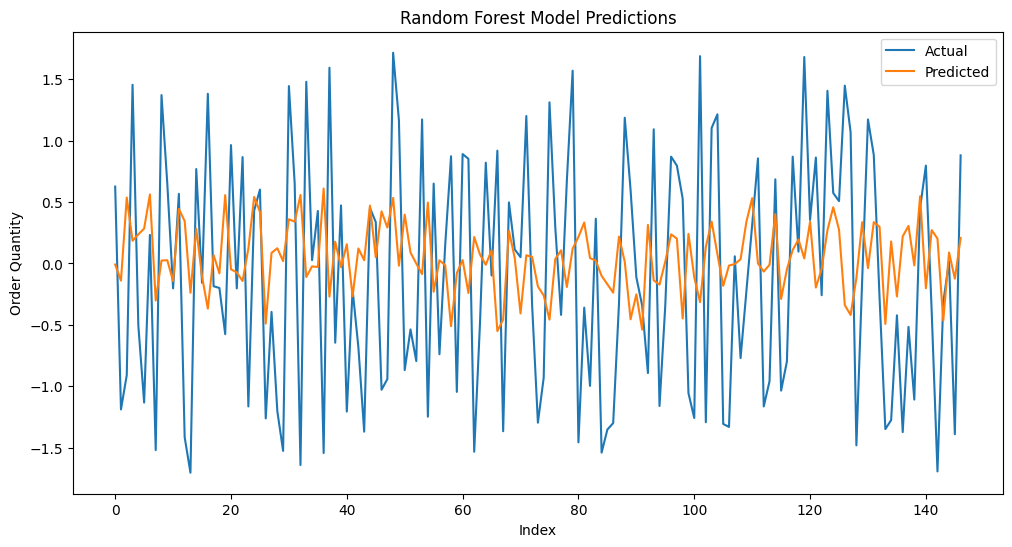

In [7]:
# Data Cleaning and Preparation
df.fillna(method='ffill', inplace=True)

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values('timestamp')

# Extract numerical features from timestamp
df['timestamp_dayofweek'] = df['timestamp'].dt.dayofweek
df['timestamp_hour'] = df['timestamp'].dt.hour

# Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Now drop the original 'timestamp' column as it's no longer needed
df = df.drop('timestamp', axis=1)

# Handle NaN and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['order_quantity', 'bid_price', 'timestamp_dayofweek', 'timestamp_hour']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Splitting data into features and target
X = df.drop(['order_quantity'], axis=1)
y = df['order_quantity']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model
model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Predicting with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Order Quantity')
plt.title('Random Forest Model Predictions')
plt.legend()
plt.show()